# Import

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

import matplotlib as mpl
from cycler import cycler
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
       
mpl.rcParams['font.size']=25
# mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

# plt.style.use('../hnc_paper_MM.mplstyle')

# Function that sets up HNC QSP 

In [2]:
Element_name = 'Aluminum'
Al_file = "data/Al-rho=2,70-2023-09-03.dat"

Z, A = 13, 26
ni_cc = 6.03e22
ri_AU = rs_from_n(ni_cc)*cm_to_AU
Al_df = read_csv(Al_file, delim_whitespace = True, header=0)

Al_Zbars = Al_df['Z_bar'][2:] 
Al_TeVs = Al_df['Te(eV)'][2:]
Al_Zbars, Al_TeVs

# TCCW Submission Data point
tccw_nicc = ni_cc
tccw_TeV = 1
tccw_η_cgs = 1.068e-02	 
tccw_η_cgs_err = 1.018e-03   

In [3]:
r_c = 0.6

In [4]:
plasma_svt_func = lambda T_eV, ni_cc, Zbar: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, 
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':True}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':250},
                 hnc_solve_options={'alpha_Picard':0.1},
                 root_options={'options':{'maxfev':50000,'xtol':1e-14}})

In [5]:
plasma_oz_func = lambda T_eV, ni_cc, Zbar: PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, 
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':True}, 
                 qsp_options={'r_c':r_c},
                 hnc_options={'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.25,'num_iterations':10000})

In [6]:
def make_Ashcroft_βvei(atom, α=1, Rc = 0.4):
    k = atom.hnc.k_array
    βvei= atom.hnc.FT_k_2_r(  4*π*atom.qsp.Γei* (np.cos(k*Rc)*(1-α) + α*np.sin(k*Rc)/(k*Rc)) * (1/k**2 - 1/(k**2 + 1/atom.qsp.Λei**2)) )
    atom.hnc.βu_r_matrix[0,1] = βvei
    atom.hnc.βu_r_matrix[1,0] = βvei
    atom.hnc.set_βu_matrix(atom.hnc.βu_r_matrix)

def new_plasma_svt_func(T_eV, ni_cc, α=1, Rc=0.5, Zbar=Z, closure='svt'):
    plasma = PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options = {'Te_c_type':'VMC'},
             hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':closure},
             hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
             root_options={'options':{'maxfev':100,'xtol':1e-14}})
    
    # Make the smoothed Ashcroft potential 
    make_Ashcroft_βvei(plasma, α=α, Rc = Rc)
    
    return plasma

## Born Green Viscosity
See [Morioka 2004](https://www.sciencedirect.com/science/article/pii/S0022309304003692)

\begin{align}
η = f_{BG} \frac{2 \pi}{15} \left(\frac{M}{RT} \right)^{1/2} \frac{n^2}{N_a} \int^\infty_0 g(r) \frac{d\phi}{dr}r^4 dr
\end{align}
Resulting units is Pa s


In [7]:
from scipy.integrate import simpson

def get_ηBG(plasma, units = 'SI', plot = False):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    ##
    if plot==True:
        fig, ax = plt.subplots()
        ax.plot(r_array, dφdr*r_array**4)
    ###
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    η_SI = η*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
    η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
    
    # print and return only specified unit
    if units=='SI' or units=='si':
        print(f"SI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
        return η_SI
    elif units=='cgs':
        print(f"CGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")
        return η_cgs
    elif units=='AU':
        return η

In [8]:
# Get list of viscosities

Al_η_cgs = np.zeros_like(Al_TeVs)
plasma_list  = []*len(Al_η_cgs)

for i, (T_eV, Zbar) in enumerate(zip(  Al_TeVs, Al_Zbars  )):
    plasma = new_plasma_svt_func(T_eV, ni_cc, Zbar=Zbar)
    plasma_list.append(plasma)
    plasma.run_hnc()
    Al_η_cgs[i] = get_ηBG(plasma, units='cgs')
    

Te_in_eV: 0.500
Ti_in_eV: 0.500
0: Initial condition Total Error: 2.045e+01
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 521
Final iter:524, Total Error: 8.758e-09
CGS: η = 3.364e-02 [g cm^-1 s^-1]
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 1.274e+01
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 513
Final iter:516, Total Error: 1.995e-09
CGS: η = 2.875e-02 [g cm^-1 s^-1]
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 7.798e+00
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 502
Final iter:505, Total Error: 9.060e-09
CGS: η = 2.485e-02 [g cm^-1 s^-1]
Te_in_eV: 5.000
Ti_in_eV: 5.000
0: Initial condition Total Error: 3.946e+00
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 499
Final iter:502, Total Error: 9.879e-11
CGS: η = 2.005e-02 [g cm^-1 s^

## Plot viscocities

In [9]:
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if not precision:
        precision = decimal_digits

    return r"${0:.{2}f} \times 10^{{{1:d}}}$".format(coeff, exponent, precision)


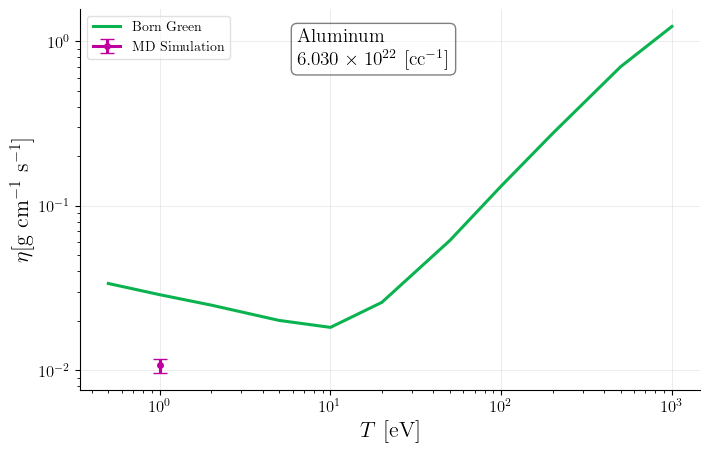

In [106]:
fig, ax = plt.subplots( facecolor='white')

ax.plot(Al_TeVs, Al_η_cgs, label='Born Green')

ax.set_ylabel(r"$\eta $[g cm$^{-1}$ s$^{-1}$]")
ax.set_xlabel(r"$T$ [eV]")

# Inset Text Box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = f"{Element_name}\n {sci_notation(ni_cc,3)} [cc$^{{-1}}$]" 
ax.text(0.35, 0.95, inset_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.errorbar([tccw_TeV],[tccw_η_cgs], yerr=[tccw_η_cgs_err], barsabove=True, capsize=5, marker='.', label='MD Simulation')

# Scales
ax.set_yscale('log')
ax.set_xscale('log')

# Legend
ax.legend()


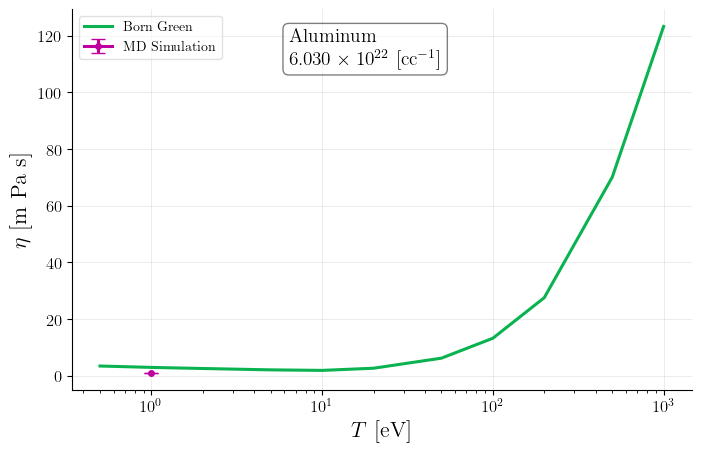

In [175]:
fig, ax = plt.subplots( facecolor='white')

cgs_to_mPas = 1/10 * 1000
ax.plot(Al_TeVs, Al_η_cgs*cgs_to_mPas, label='Born Green')

ax.set_ylabel(r"$\eta$ [m Pa s]")
ax.set_xlabel(r"$T$ [eV]")

# Inset Text Box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = f"{Element_name}\n {sci_notation(ni_cc,3)} [cc$^{{-1}}$]" 
ax.text(0.35, 0.95, inset_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.errorbar([tccw_TeV],[tccw_η_cgs*cgs_to_mPas], yerr=[tccw_η_cgs_err], barsabove=True, capsize=5, marker='.', label='MD Simulation')

# Scales
# ax.set_yscale('log')
ax.set_xscale('log')

# Legend
ax.legend()


In [12]:
header = "T[eV] Zbar η[g/(cms)] η[mPas]"
np.savetxt("./data/η_cgs_Al_VMC_Rc0.5_α1.dat", np.array([Al_TeVs, Al_Zbars, Al_η_cgs, Al_η_cgs*cgs_to_mPas]).T , header = header ,comments='')

In [13]:
Al_TeVs

2        0.5
3        1.0
4        2.0
5        5.0
6       10.0
7       20.0
8       50.0
9      100.0
10     200.0
11     500.0
12    1000.0
Name: Te(eV), dtype: float64

## Conductivity from Ziman

https://arxiv.org/pdf/1508.06101.pdf eq.5 in Hansen & McDonald the eqn's 10.2.4, 10.2.11

$$
\sigma^{-1} = \rho= \frac{1}{32 \sqrt{\pi} Z} \frac{m_e^2}{(2 m_e T_e^c)^{3/2}} \int^{\infty}_0 e^{-q^2/(8 m_e T_e^c)}  |\tilde{V}(q)|^2 S_{ii}(q) q^3 dq
$$
where the screened potential 
$$\tilde{V}(q) = V(q)/\epsilon,$$
for $$\frac{1}{\epsilon}  = 1 + \frac{4 \pi}{k^2}\chi_{ee}(k) $$ 
and 
$$\chi_{ee}(k) = -\beta_e^c n_e S_{ee}(k) $$

In [180]:
from scipy.integrate import simpson

def conductivity(plasma):
    q_array = plasma.hnc.k_array/plasma.qsp.ri 
    
    rhosum = np.sum(plasma.hnc.rho/plasma.qsp.ri**3)
    x = plasma.hnc.rho/plasma.qsp.ri**3/rhosum
    S_matrix = np.diag(x)[:,:,np.newaxis] + rhosum * x[:,np.newaxis,np.newaxis]*x[np.newaxis,:,np.newaxis]*plasma.hnc.h_k_matrix
    χ_ee = -plasma.qsp.βe_c*plasma.qsp.ne*S_matrix[1,1]
    kTF = plasma.qsp.get_κ()/plasma.qsp.ri
    χ_ee = -q_array**2/(4*π)* kTF**2/(kTF**2 + q_array**2)
    ε = 1/( 1 + 4*π/q_array**2 * χ_ee)
    Vtilde = -plasma.Zbar/(plasma.hnc.r_array*plasma.qsp.ri)/ε
    # print(ε)
    integrand = np.exp(-plasma.qsp.βe_c * q_array**2/8) * np.abs(Vtilde)**2 * S_matrix[0,0] * q_array**3
    ρ_AU = 1/(  32*np.sqrt(π)*plasma.Zbar*(2*plasma.qsp.Te_c)**1.5) * simpson(integrand, q_array)  
    σ_AU = 1/ρ_AU
    σ_Spercm = σ_AU * AU_to_Siemens/AU_to_cm
    return σ_Spercm
print(f"Conductivity: σ = {conductivity(plasma):0.3e}")

Conductivity: σ = 2.603e+05


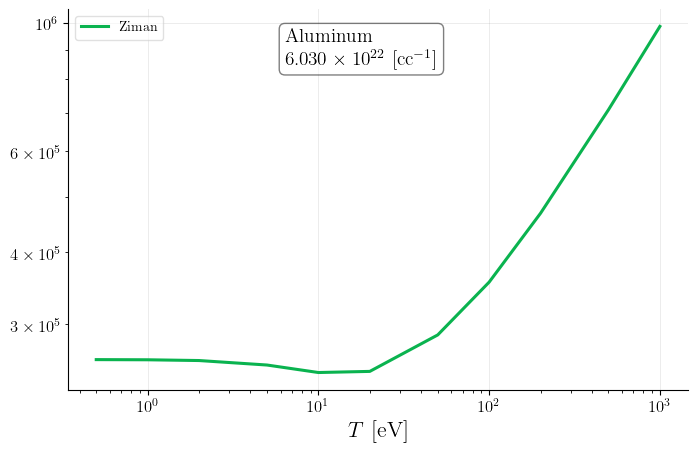

In [181]:
fig, ax = plt.subplots( facecolor='white')

ax.plot(Al_TeVs, [conductivity(plasma) for plasma in plasma_list], label='Ziman')

# ax.set_ylabel(r"$\eta $[g cm$^{-1}$ s$^{-1}$]")
ax.set_xlabel(r"$T$ [eV]")

# Inset Text Box
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = f"{Element_name}\n {sci_notation(ni_cc,3)} [cc$^{{-1}}$]" 
ax.text(0.35, 0.95, inset_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# ax.errorbar([tccw_TeV],[tccw_η_cgs], yerr=[tccw_η_cgs_err], barsabove=True, capsize=5, marker='.', label='MD Simulation')

# Scales
ax.set_yscale('log')
ax.set_xscale('log')

# Legend
ax.legend()


## Other plots at 1 eV

In [145]:
MD_data = read_csv("/home/zach/plasma/datasets/RDFs/Al_1.0eV_rs3_VASP.txt",  header=1)
MD_data.columns=['r','g']
MD_data;

In [15]:
ocp =  PLASMA(Z, A, ni_cc, 1, 1, Zbar=3, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
ocp.run_ocp_hnc();
yp =  PLASMA(Z, A, ni_cc, 1, 1, Zbar=3, find_βuee=True,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
yp.run_yukawa_hnc();

Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 2.808e+01
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 511
Final iter:514, Total Error: 3.824e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000


/home/zach/plasma/hnc/hnc/PIE.py:163: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0: Initial condition Total Error: 3.223e+01
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 499
Final iter:502, Total Error: 8.386e-09


### Potential Inputs

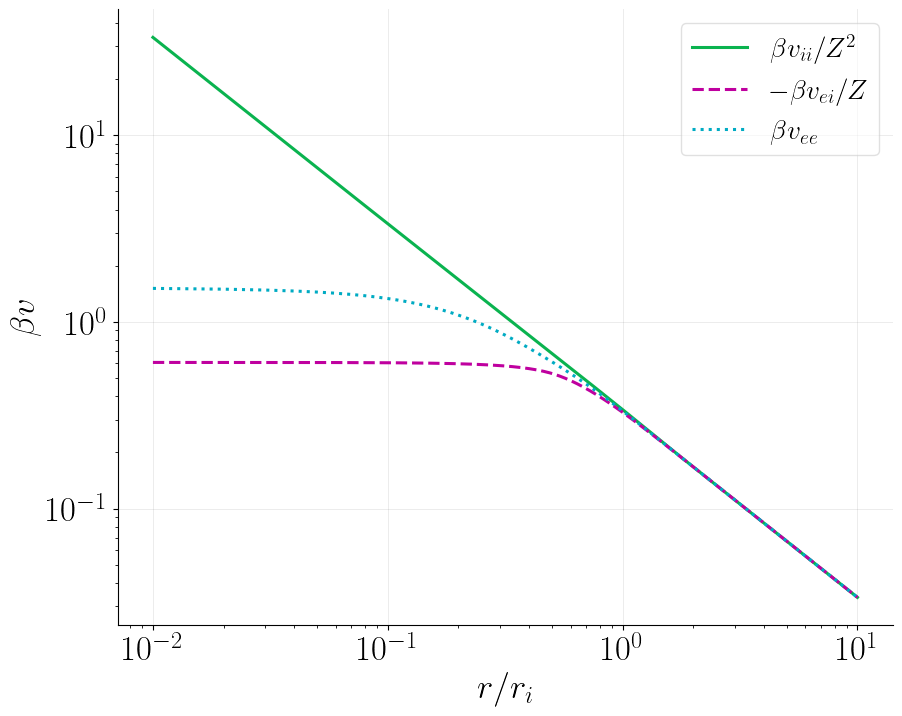

In [103]:
fig, ax = plt.subplots(figsize=(10,8))
# ax.set_title("Continuous Smoothed Ashcroft", fontsize=20)

colors = plt.cm.coolwarm(np.linspace(0,1,len(plasma_list) ))

# QSP
plasma = plasma_list[np.argmin(np.abs(1-Al_TeVs))]

ax.plot(plasma.hnc.r_array, (plasma.hnc.βu_r_matrix[0,0])/plasma.qsp.Zstar**2/plasma.qsp.βi, label=r"$\beta v_{ii}/Z^2$")
ax.plot(plasma.hnc.r_array, -(plasma.hnc.βu_r_matrix[0,1])/plasma.qsp.Zstar/plasma.qsp.βie_c,'--', label=r"$-\beta v_{ei}/Z$")
ax.plot(plasma.hnc.r_array, plasma.hnc.βu_r_matrix[1,1]/plasma.qsp.βe_c, ':',label=r"$\beta v_{ee}$")

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
# ax.set_xlim(0,6)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$\beta v$',fontsize=25)
ax.set_xlabel(r'$r/r_i$ ',fontsize=25)
ax.tick_params(labelsize=25)
# ax.set_yscale('symlog', linthresh=2)
ax.set_xscale('log')
ax.set_yscale('log')

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=20)
plt.savefig('βu_plots.png', dpi=400)

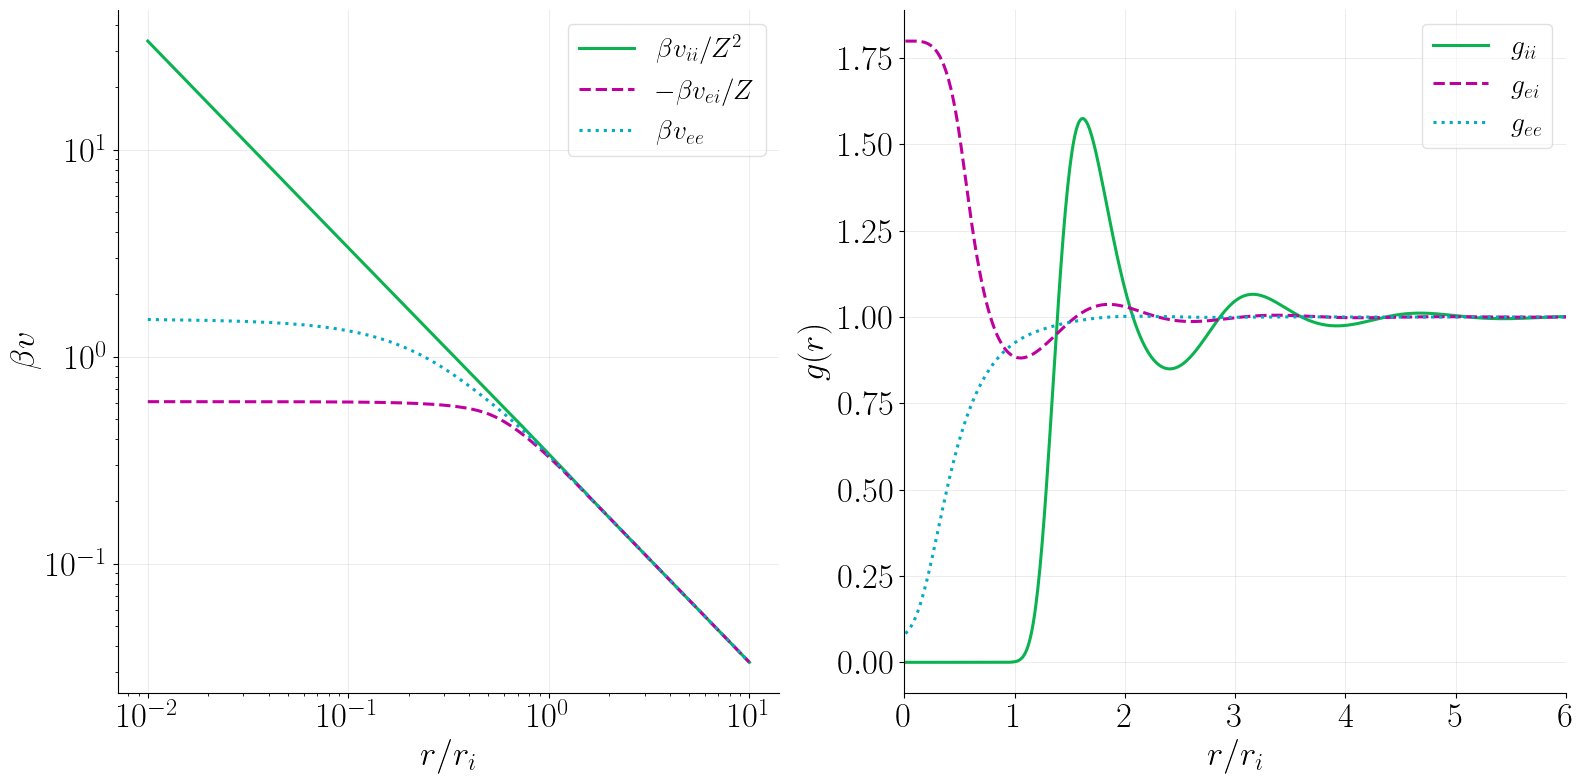

In [95]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

colors = plt.cm.coolwarm(np.linspace(0,1,len(plasma_list) ))

plasma = plasma_list[np.argmin(np.abs(1-Al_TeVs))]
# βu
axs[0].plot(plasma.hnc.r_array, (plasma.hnc.βu_r_matrix[0,0])/plasma.qsp.Zstar**2/plasma.qsp.βi, label=r"$\beta v_{ii}/Z^2$")
axs[0].plot(plasma.hnc.r_array, -(plasma.hnc.βu_r_matrix[0,1])/plasma.qsp.Zstar/plasma.qsp.βie_c,'--', label=r"$-\beta v_{ei}/Z$")
axs[0].plot(plasma.hnc.r_array, plasma.hnc.βu_r_matrix[1,1]/plasma.qsp.βe_c, ':',label=r"$\beta v_{ee}$")
axs[0].set_ylabel(r'$\beta v$',fontsize=25)
axs[0].set_yscale('log')
axs[0].set_xscale('log')


# g(r)
axs[1].plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1, label=r"$g_{ii}$")
axs[1].plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,1]+1, '--', label=r"$g_{ei}$")
axs[1].plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[1,1]+1, ':',label=r"$g_{ee}$")
# axs[1].set_yscale('log')
axs[1].set_xlim(0,6)
axs[1].set_ylabel(r'$g(r)$',fontsize=25)

for ax in axs:
    ax.set_xlabel(r'$r/r_i$ ',fontsize=25)
    ax.tick_params(labelsize=25)
    # ax.set_yscale('symlog', linthresh=2)
    ax.legend(fontsize=20)
    
plt.tight_layout()
plt.savefig('βu_gij_Al1.png', dpi=800)

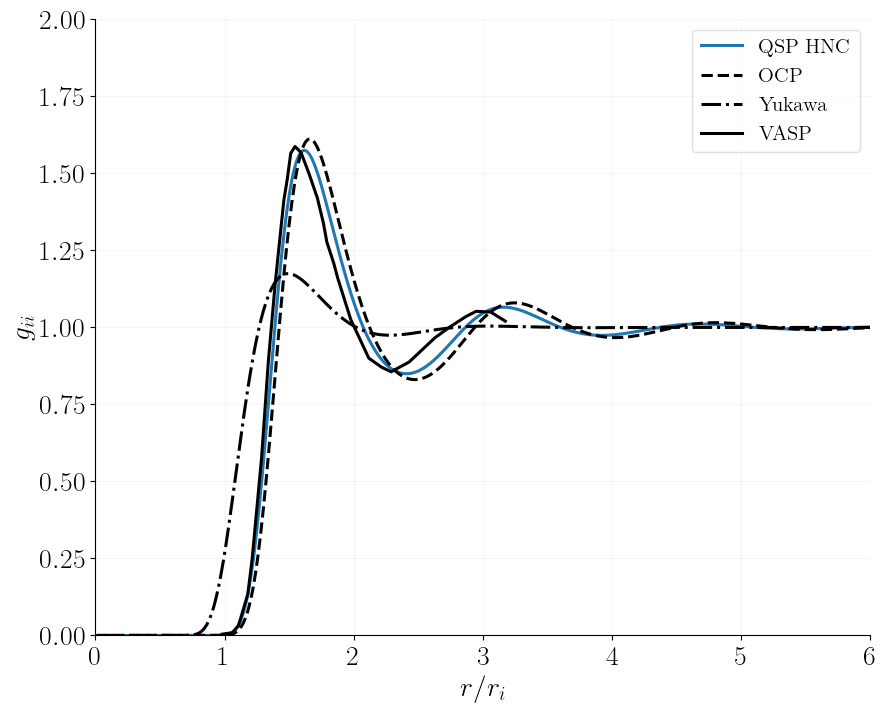

In [21]:
fig, ax = plt.subplaots(figsize=(10,8))
# ax.set_title("Continuous Smoothed Ashcroft", fontsize=20)

colors = plt.cm.coolwarm(np.linspace(0,1,len(plasma_list) ))

# QSP
plasma = plasma_list[np.argmin(np.abs(1-Al_TeVs))]
ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1, label="QSP HNC")

# OCP
ax.plot(ocp.ocp_hnc.r_array, ocp.ocp_hnc.h_r_matrix[0,0]+1,'k--', label='OCP')
ax.plot(yp.yuk_hnc.r_array, yp.yuk_hnc.h_r_matrix[0,0]+1,'k-.', label='Yukawa')

# Data
ax.plot(MD_data['r'], MD_data['g'], 'k',label='VASP')

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(0,6)
ax.set_ylim(0,2)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=2)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=15)

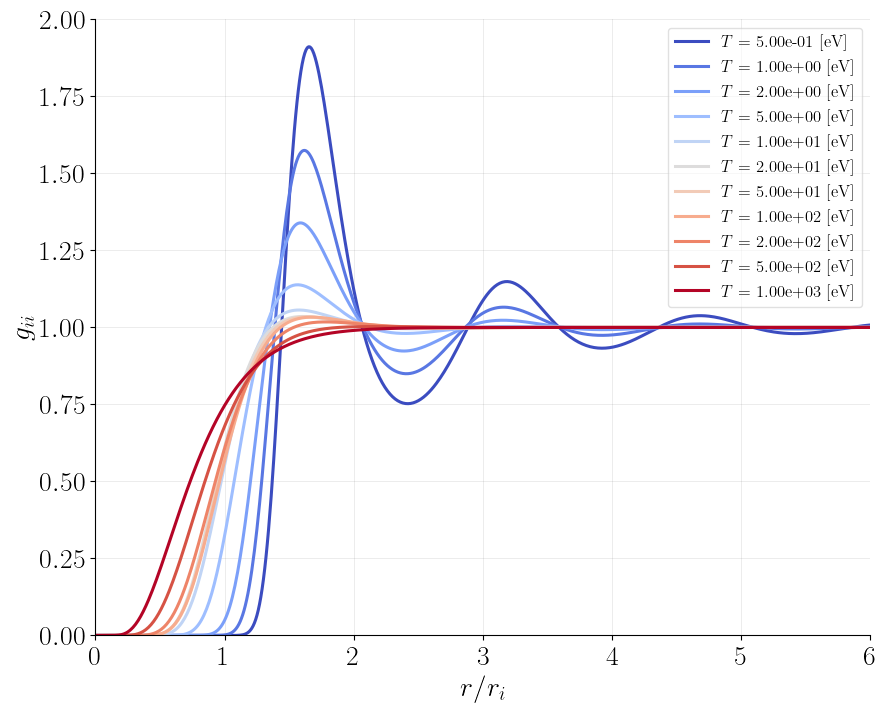

In [186]:
fig, ax = plt.subplots(figsize=(10,8))
# ax.set_title("Continuous Smoothed Ashcroft", fontsize=20)

# QSP
colors = plt.cm.coolwarm(np.linspace(0,1,len(plasma_list) ))

for i, (color, T_eV, plasma) in enumerate(zip(colors, Al_TeVs, plasma_list)):
    # if i>2:
    #     continue
    ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1,'-', color=color,label=r"$T$ = {0:.2e} [eV]".format(T_eV))

# plasma = plasma_list[np.argmin(np.abs(1-Al_TeVs))]
# ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1, label="QSP HNC")

# OCP
# ax.plot(ocp.ocp_hnc.r_array, ocp.ocp_hnc.h_r_matrix[0,0]+1,'k--', label='OCP')
# ax.plot(yp.yuk_hnc.r_array, yp.yuk_hnc.h_r_matrix[0,0]+1,'k-.', label='Yukawa')

# Data
# ax.plot(MD_data['r'], MD_data['g'], 'k',label='VASP')

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(0,6)
ax.set_ylim(0,2)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=2)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=12, loc='upper right')



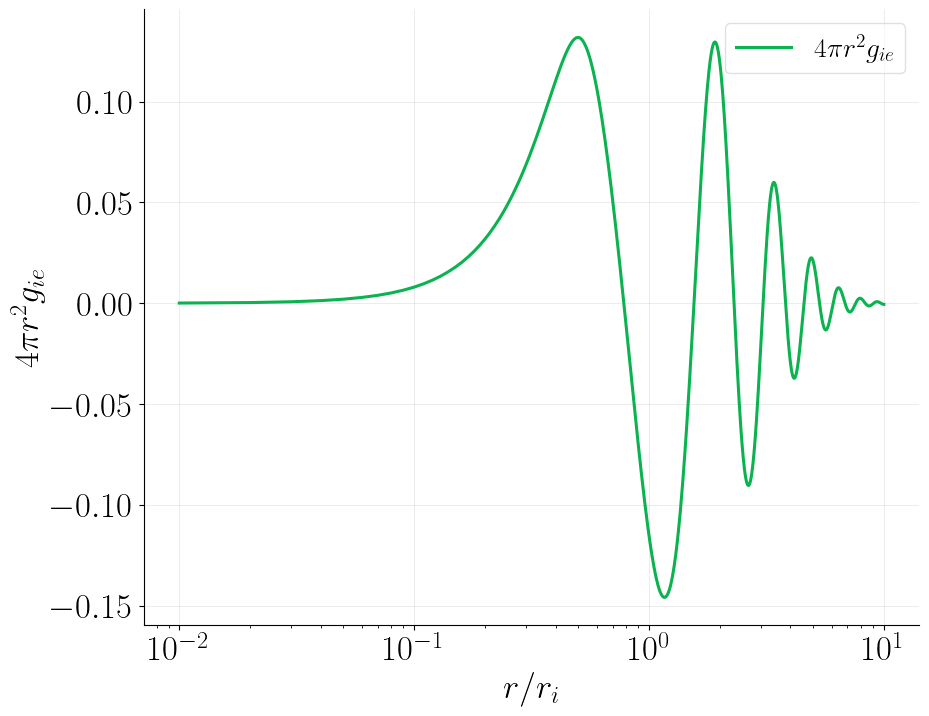

In [193]:
fig, ax = plt.subplots(figsize=(10,8))
# ax.set_title("Continuous Smoothed Ashcroft", fontsize=20)

colors = plt.cm.coolwarm(np.linspace(0,1,len(plasma_list) ))

# QSP
plasma = plasma_list[np.argmin(np.abs(1-Al_TeVs))]

ax.plot(plasma.hnc.r_array, plasma.hnc.r_array**2 * (plasma.hnc.h_r_matrix[0,1]) , label=r"$4 \pi r^2 g_{ie} $")

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
# ax.set_xlim(0,6)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$4 \pi r^2 g_{ie}$',fontsize=25)
ax.set_xlabel(r'$r/r_i$ ',fontsize=25)
ax.tick_params(labelsize=25)
# ax.set_yscale('symlog', linthresh=2)
ax.set_xscale('log')
# ax.set_yscale('log')

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=20)
plt.savefig('βu_plots.png', dpi=400)

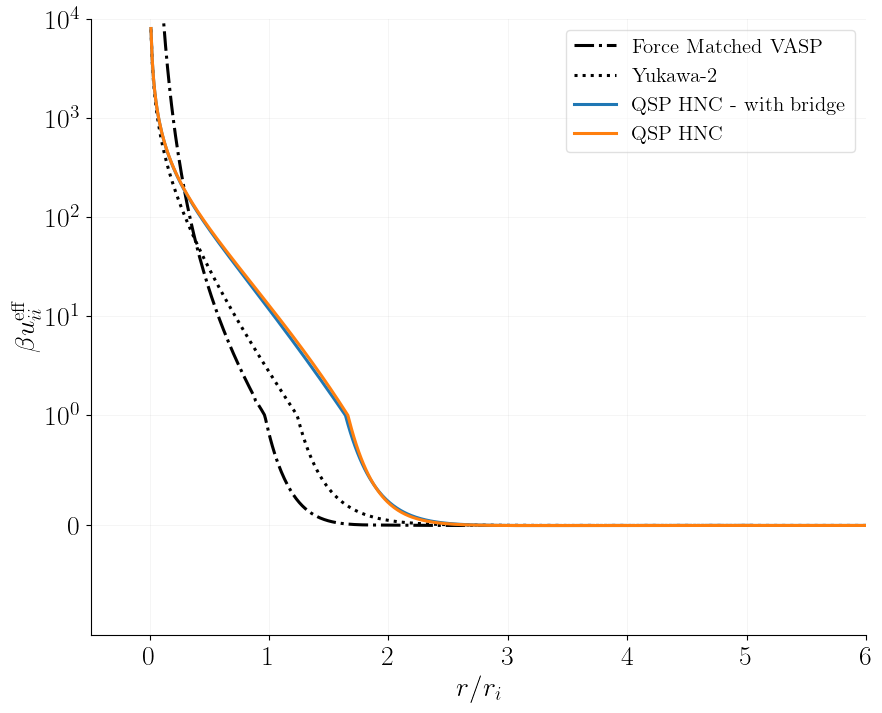

In [17]:
Luke_pair = read_csv("data/Al_T1_tab.lammps.PAIR", delim_whitespace=True, header=4)


fig, ax = plt.subplots(figsize=(10,8))

# LUKE Potfit VASP
ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, plasma.qsp.βie_c*Luke_pair['u[eV]']*eV_to_AU, 'k-.',label='Force Matched VASP')
# ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, 1/(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU)**4.25, 'k:',label='Force Matched VASP')
# Coulomb and Yukawa
yp.yuk_hnc.invert_HNC_OZ([])
# custom.ocp_hnc.invert_HNC_OZ([])
# ax.plot(plasma.hnc.r_array, plasma.hnc.βu_r_matrix[0,0],'k-', label='Coulomb')
# ax.plot(plasma.hnc.r_array, plasma.qsp.βv_Yukawa(plasma.hnc.r_array),'k--', label='Yukawa')
ax.plot(plasma.hnc.r_array, yp.yuk_hnc.βueff_r_matrix[0,0],'k:', label='Yukawa-2')
plasma.βueff_r_matrix_with_B = np.array([[plasma.hnc.βueff_r_matrix[0,0] + plasma.hnc.Bridge_function_Yukawa(plasma.hnc.r_array, plasma.qsp.Γii, plasma.qsp.get_κ())]])
ax.plot(plasma.hnc.r_array, plasma.βueff_r_matrix_with_B[0,0], label='QSP HNC - with bridge')
ax.plot(plasma.hnc.r_array, plasma.hnc.βueff_r_matrix[0,0], label='QSP HNC')

# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(None,6)
ax.set_ylim(-1,1e4)
ax.set_ylabel(r'$\beta u^{\text{eff}}_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('symlog', linthresh=1)
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend(fontsize=15)

In [18]:
np.savetxt("Al1_βu_eff_raw.txt", np.array([plasma.hnc.r_array,plasma.βueff_r_matrix_with_B[0,0] ]).T, header='r/r_i 			 βuii_eff(r/r_i)')
np.savetxt("Al1_g_r_raw.txt", np.array([plasma.hnc.r_array,plasma.hnc.h_r_matrix[0,0]+1, plasma.hnc.h_r_matrix[1,0]+1,plasma.hnc.h_r_matrix[1,1]+1 ]).T, header='r/r_i 				 gii(r/r_i) 				 gie(r/r_i) 				 gee(r/r_i)')